In [3]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import statsmodels.stats as stat
import sys
import scipy.stats as stat
import sympy as sy
from sympy.stats import Normal, cdf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightgbm as lgb
import sklearn as sk
torch.cuda.empty_cache()
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

In [4]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install

os.chdir('../')
!pip install TA-Lib

--2022-08-23 21:16:55--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-23 21:16:56--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-23 21:16:56--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [24]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [29]:
def Backtest(pcpl1):

    pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']
    
    # 手续费
    time0 = pcpl1['time'].sort_values().iloc[0]
    timen = pcpl1['time'].sort_values().iloc[-1]
    
    pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
    # pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
    pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
    pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0
    
    pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
    pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
    pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
    pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'open price']
    pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position']) * 0.05 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']
    
    pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
    pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
    pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
    pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
    pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'open price']
    pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position']) * 0.05 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']
    
    
    # cash = pcpl1.groupby('time')['cash_diff'].sum()
    
    pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
    pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
    pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
    pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
    pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
    pcpl1['margin'] = pcpl1['margin']/0.8
    pcpl1.loc[pcpl1['type'] == 'S', 'margin'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position']) * pcpl1.loc[pcpl1['type'] == 'S', 'open price'] * 1e4
    pcpl1['margin'] = pcpl1['margin'].fillna(0)
    pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
    pcpl1['cost'] = pcpl1['cost'].fillna(0)
    pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
    pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']
    # cash = pcpl1.groupby('time')['cash'].sum()
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.title('Return Decomposition')
    pcpl1['delta_p'] = pcpl1['delta']*pcpl1['position']
    delta_p = pcpl1.groupby('time')['delta_p'].sum()
    delta_p = (pcpl1.loc[pcpl1['type'] == 'S', 'close'] - pcpl1.loc[pcpl1['type'] == 'S', 'open price']).values * delta_p * 1e4
    pcpl1['vega_p'] = pcpl1.groupby('code')['sabr vol'].diff()
    pcpl1['arbi'] = pcpl1.groupby('code')['black vol'].diff() - pcpl1['vega_p']
    pcpl1['arbi'] = pcpl1['arbi'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
    pcpl1['vega_p'] = pcpl1['vega_p'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
    pcpl1['gamma_p'] = pcpl1['gamma']*pcpl1['position'].values
    gamma_p = pcpl1.groupby('time')['gamma_p'].sum()
    gamma_p = ((pcpl1.loc[pcpl1['type'] == 'S', 'close'] - pcpl1.loc[pcpl1['type'] == 'S', 'open price']).values)**2 * gamma_p/2 * 1e4
    pcpl1['theta_p'] = pcpl1.groupby('code')['time_to_mature'].diff()
    pcpl1['theta_p'] = pcpl1['theta_p'] * pcpl1['theta'].values * pcpl1['position'].values * 1e4
    plt.plot(delta_p.cumsum(), label='delta')
    plt.plot(pcpl1.groupby('time')['vega_p'].sum().cumsum(), label='vega')
    plt.plot(gamma_p.cumsum(), label='gamma')
    plt.plot(pcpl1.groupby('time')['theta_p'].sum().cumsum(), label='theta')
    plt.plot(pcpl1.groupby('time')['arbi'].sum().cumsum(), label = 'vol shift')
    plt.legend()
    
    
    plt.figure(figsize = (10, 5))
    plt.title('Strategy Return')
    plt.plot(pcpl1.groupby('time')['cash'].sum().cumsum(), label = 'Return Without Cost')
    plt.plot(pcpl1.groupby('time')['cash_net'].sum().cumsum(), label = 'Return With Cost')
    plt.plot(delta_p.cumsum()+pcpl1.groupby('time')['vega_p'].sum().cumsum()+gamma_p.cumsum()+pcpl1.groupby('time')['theta_p'].sum().cumsum()+pcpl1.groupby('time')['arbi'].sum().cumsum(), label='Greeks Return')
    plt.legend()
    
    
    plt.figure(figsize = (10, 5))
    plt.title('Cost Decomposition')
    plt.stackplot(np.unique(pcpl1['time']), pcpl1.groupby('time')['profit_cost'].sum().cumsum(), pcpl1.groupby('time')['hedge_cost'].sum().cumsum())
    plt.plot(pcpl1.groupby('time')['cost'].sum().cumsum(), color='r')
    
    
    pcpl1['notional'] = np.abs(pcpl1['position'] * pcpl1['spot price'])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(pcpl1.groupby('time')['notional'].sum(), c='b',ls='--',label='notional amount')
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel('Notional Amount', color='b', fontsize=16)
    ax.tick_params('y', colors='b')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(pcpl1.loc[pcpl1['position'] != 0, :].groupby('time').size(), c='r', ls=":",label='Position')
    ax2.set_ylabel('Contract Number',color='r', fontsize=16)
    ax2.tick_params('y', colors='r')
    ax2.legend()
    
    plt.title('Position Fluctuate', fontsize=16)
    plt.show()   
    
    # 策略评价指标
    strategy = {}
    # initial capital as 3e7
    cash_cum = pcpl1.groupby('time')['cash_net'].sum().reset_index()
    cash_cum['capital'] = pcpl1.groupby('time')['margin'].sum().reset_index(drop = True)
    cash_cum['ret'] = cash_cum['cash_net']/cash_cum['capital']
    cash_cum.dropna(inplace = True)
    cash_cum = cash_cum.loc[cash_cum['capital']!=0, :]
    strategy['annualized return'] = cash_cum['ret'].sum() * (250 * 48/len(cash_cum))
    strategy['sharpe ratio'] = (strategy['annualized return'] - 0.04) / cash_cum['ret'].std()*np.sqrt(250*48)
    strategy['maximum drawdown'] = (cash_cum['ret'].cumsum() - cash_cum['ret'].cumsum().cummax()).min()
    strategy['win ratio'] = (cash_cum['ret'] > 0).sum()/len(cash_cum)
    print(pd.DataFrame(strategy, index = [0]))
    
    return 0

In [6]:
def euro_vanilla_option(S, K, T, r,sigma,isCall):
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if isCall == 1:
        phi = 1
    else:
        phi = -1
    
    return phi*(S*stat.norm.cdf(phi*d1) - K*np.exp(-r*T)*stat.norm.cdf(phi*d2))

def BS_price(df):
    k = df['strike price']
    s = df['spot price']
    iscall = df['C']
    expiry = df['time_to_mature']
    rf = df['riskfree rate']
    sigma = df['sabr vol']
    return pd.Series({'sabr_value':euro_vanilla_option(s,k,expiry,rf,sigma,iscall)})

In [7]:
import talib
#feature engineering
def feature_engineering(data):
    df = data.copy()
    df['close_ma_25min'] = talib.MA(df['close'],5)
    df['close_ma_75min'] = talib.MA(df['close'],15)
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ma_diff_5'] = df['close'] - df['close_ma_25min']
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    
    return df
def feature_engineering_vol(data):
    df = data.copy()
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    df['vol_ema_25min'] = talib.EMA(df['sabr vol'],5)
    df['vol_ema_75min'] = talib.EMA(df['sabr vol'],15)
    df['vol_ema_diff_5'] = df['sabr vol'] - df['vol_ema_25min']
    df['vol_ema_diff_15'] = df['sabr vol'] - df['vol_ema_75min']
    df['IV_per_volume'] = df['sabr vol'].diff() / df['volume']
    df['ret'] = df['close'].pct_change()
    df['cummulative_ret_25min'] = df['ret'].rolling(5).sum()
    df['cummulative_ret_75min'] = df['ret'].rolling(15).sum()
    df['aroon_up_30'],df['aroon_in_30'] = talib.AROON(df['high'],df['close'],30)
    df['CCI'] = talib.CCI(df['high'],df['low'],df['close'],30)
    df['macd_close'] = talib.MACD(df['close'],10,30,6)[0]
    df['macd_sabr_value'] = talib.MACD(df['sabr_value'],10,30)[0]
    df['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=6, timeperiod2=12, timeperiod3=24)
    df['atm_IV_ema_25min'] = talib.EMA(df['atm_IV'],5)
    df['atm_IV_ema_75min'] = talib.EMA(df['atm_IV'],15)
    df['atm_IV_MACD'] = talib.MACD(df['atm_IV'],10,30,6)[0]
       
    return df

In [8]:
def beta_calculation(df):
    df = df[['strike','sabr vol','spot price','time','code']]
    df['moneyness'] = (df['spot price']>df['strike']).apply(lambda x:1 if x else 0)
    df_OTM = df[df['moneyness']<1]
    df_ITM = df[df['moneyness']==1]
    beta_OTM_ols = np.cov(df_OTM['sabr vol'],df_OTM['strike'])[0][1]/np.var(df_OTM['strike'])
    beta_ITM_ols = np.cov(df_ITM['sabr vol'],df_ITM['strike'])[0][1]/np.var(df_ITM['strike'])
    if df_OTM['strike'].max() != df_OTM['strike'].min():
        beta_OTM = -(df_OTM['sabr vol'].max() - df_OTM['sabr vol'].min())/ (df_OTM['strike'].max() - df_OTM['strike'].min())
    else:
        beta_OTM = 0
    if df_ITM['strike'].max() != df_ITM['strike'].min():
        beta_ITM = (df_ITM['sabr vol'].max() - df_ITM['sabr vol'].min())/ (df_ITM['strike'].max() - df_ITM['strike'].min())
    else:
        beta_ITM = 0
    df_OTM_sub = df_OTM[df_OTM['strike']>df_OTM['strike'].min()]
    df_ITM_sub = df_ITM[df_ITM['strike']>df_ITM['strike'].min()]
    df_OTM_sub['beta'] = -(df_OTM_sub['sabr vol'] - df_OTM['sabr vol'].min())/(df_OTM_sub['strike'] - df_OTM['strike'].min())
    df_ITM_sub['beta'] = (df_ITM_sub['sabr vol'] - df_ITM['sabr vol'].min())/(df_ITM_sub['strike'] - df_ITM['strike'].min())
    beta_OTM_avg = df_OTM_sub['beta'].mean()
    beta_ITM_avg = df_ITM_sub['beta'].mean()
    
    atm_strike = (df_OTM.strike.max() + df_ITM.strike.min())/2
    atm_vol = (df_OTM['sabr vol'].min() + df_OTM['sabr vol'].min())/2
    df['beta'] = (df['sabr vol'] - atm_vol)/(df['strike'] - atm_strike)
    df.loc[abs(df['beta'])>1,'beta'] = 0
    df['beta_ols_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_ols if x==0 else beta_ITM_ols))
    df['beta_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM if x==0 else beta_ITM))
    df['beta_avg_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_avg if x==0 else beta_ITM_avg))
    df['atm_IV'] = atm_vol
    df = df.drop("moneyness",axis=1)
    return df

In [9]:
def make_dataset(data,y_pred='f_close_5min'):
    feature = data.copy()
    if y_pred =="f_close_5min":
        feature['f_close_5min'] = feature.groupby('code').apply(lambda x:x['close'].shift(-1)).values
    elif y_pred == "f_ret_5min":
        feature['f_ret_5min'] = feature.groupby('code').apply(lambda x:x['close'].pct_change().shift(-1)).values
    elif y_pred == "f_ret_direction":
        feature['f_ret_direction'] = ((feature.groupby('code').apply(lambda x:x['close'].shift(-1)))>0).apply(lambda x: 1 if x else 0)
    feature = feature.replace({np.inf:0,-np.inf:0})
    feature = feature.dropna()
    month_split = feature.time.apply(lambda x:x.month)
    feature_train = feature[month_split<7]
    feature_test = feature[month_split==7]
    X_train = feature_train.drop(['time','code','option_code','type','maturity_date',y_pred,'strike price'],axis=1)
    y_train = feature_train[y_pred]
    X_test = feature_test.drop(['time','code','option_code','type','maturity_date',y_pred,'strike price'],axis=1)
    y_test = feature_test[y_pred]

    return X_train,y_train,X_test,y_test,feature_train,feature_test,feature

In [10]:
work_path = "/content/drive/MyDrive/SabrSummerProject2022/"
sys.path.append(work_path + '/02_src/HedgingModel')
import hedge_update
sys.path.append(work_path + '/02_src/OptionModel')
from sabr_bywynn import BlackScholes, SABR
sabr2207 = pd.read_csv(work_path + '/03_data/300etf_2207_sabr_v1.csv',index_col = 0)
sabr2207 = sabr2207.loc[:26173, :]
sabr2207.time = pd.to_datetime(sabr2207.time)
#f = open(os.path.join(data_path, '300etf_2208_sabr_v1.pkl'),'rb')
#sabr2207 = pickle.load(f)

etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

'''
volatility spread to generate expected price spread
'''
sabr2207 = sabr2207.loc[(np.abs(sabr2207['delta']) < 0.9)&(np.abs(sabr2207['delta']) > 0.1), :]

def gen_price(x):
    isCall = x['type'].apply(lambda x: True if x == 'C' else False)
    bs = BlackScholes(x['strike price'], x['time_to_mature'].values[0], x['spot price'].values[0], x['riskfree rate'].values[0], isCall)
    x['price'] = bs.black(x['sabr vol'])   
    return x

sabr2207 = sabr2207.groupby('time').apply(gen_price)

In [11]:
import talib
sabr2207 = sabr2207.rename(columns={'price':'sabr_value'})
vol_beta = sabr2207.groupby('time',as_index=True).progress_apply(lambda x:beta_calculation(x))
sabr2207 = pd.merge(sabr2207,vol_beta[["code","time","beta","beta_ols_diff","beta_diff","beta_avg_diff",'atm_IV']],on = ["code","time"])
sabr2207 = sabr2207.groupby('code').progress_apply(lambda x:feature_engineering_vol(x))
sabr2207['volume'] = np.log(sabr2207['volume'])

my bars:: 100%|██████████| 27/27 [00:00<00:00, 48.60it/s]


In [12]:
X_train,y_train,X_test,y_test,feature_train,feature_test,feature = make_dataset(sabr2207,y_pred = 'f_close_5min')

In [14]:
#RandomForest grid Search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
estimator = RandomForestRegressor()
# param_grid = {
#     'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],
#     'max_features':['auto',10,20],
#     'max_depth' : [int(x) for x in np.linspace(10, 60, num = 5)],
#     'bootstrap' : [True, False] 
# }
param_grid = {
    'n_estimators':[200,500,800],
    'max_features':['auto',15],
    'bootstrap' : [True, False] 
}
kfold = KFold(n_splits=10, shuffle = True,random_state=7)
rf = GridSearchCV(estimator, param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=kfold)
rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 15],
                         'n_estimators': [200, 500, 800]},
             scoring='neg_mean_squared_error')

In [20]:
joblib.dump(rf, '/content/drive/MyDrive/Huatai_ml_model/best_Rf_close_47feature.pkl')
drive.flush_and_unmount() 

In [21]:
feature_train['model close'] = rf.predict(X_train)
feature_test['model close'] = rf.predict(X_test)

In [22]:
sabr2207_strat = pd.concat([feature_train, feature_test])
sabr2207_strat['time'] = pd.to_datetime(sabr2207_strat['time'])
sabr2207_strat['signal'] = -sabr2207_strat['close'] + sabr2207_strat['model close']
sabr2207_strat[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207_strat.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()
sabr2207_strat = sabr2207_strat.sort_values(['time', 'code'])

In [25]:
etf = pd.read_csv(work_path + "/03_data/300etf.csv",index_col = 0)
etf['time'] = pd.to_datetime(etf['time'])
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

# param_dict_ = {'by_rank':2, 'symmetry':True}
# # param_dict_ = {'bar':1e-3}
# strat = sabr2207.groupby('time').apply(hedge_update.Option_Split_Rank, **param_dict_)
# pcpl1 = hedge_update.Hedge_Transform(strat, etf)
# hedge_update.Global_Exist(pcpl1)
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Option_Position_Add).reset_index(drop = True)
# # temp.to_csv('/Users/chenwynn/Documents/Intern_project/HTSC_Summer/sabr_vol/add.csv')
# hedge_update.Global_Exist(pcpl1)
# hedge_dict_ = {'bar':8e-4, 'delta_tolerance':5, 'vega_tolerance':5}
# pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Vega, **hedge_dict_).reset_index(drop = True)

# pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

# strategy 1
param_dict_ = {'profit':1e-3, 'hedge':8e-4, 'delta_tolerance':20, 'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl1 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl1['profit_position'] = 0
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Open, **param_dict_).reset_index(drop = True)
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

my bars::   4%|▍         | 82/2016 [00:03<01:35, 20.30it/s]

Positive directional derivative for linesearch


my bars::   7%|▋         | 141/2016 [00:07<01:44, 17.87it/s]

Optimization terminated successfully


my bars::   8%|▊         | 169/2016 [00:08<01:19, 23.23it/s]

Optimization terminated successfully


my bars::  15%|█▍        | 299/2016 [00:19<01:57, 14.62it/s]

Optimization terminated successfully


my bars::  16%|█▌        | 320/2016 [00:21<03:03,  9.24it/s]

Positive directional derivative for linesearch


my bars::  19%|█▉        | 380/2016 [00:25<01:14, 22.05it/s]

Positive directional derivative for linesearch


my bars::  21%|██        | 414/2016 [00:27<01:15, 21.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 540/2016 [00:35<00:37, 39.12it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 550/2016 [00:35<00:35, 41.31it/s]

Optimization terminated successfully


my bars::  28%|██▊       | 572/2016 [00:36<00:42, 34.34it/s]

Optimization terminated successfully


my bars::  29%|██▉       | 586/2016 [00:37<01:46, 13.38it/s]

Optimization terminated successfully


my bars::  31%|███▏      | 635/2016 [00:41<03:29,  6.60it/s]

Optimization terminated successfully


my bars::  35%|███▌      | 714/2016 [00:50<00:58, 22.21it/s]

Optimization terminated successfully


my bars::  39%|███▉      | 789/2016 [00:56<00:52, 23.22it/s]

Optimization terminated successfully


my bars::  43%|████▎     | 864/2016 [01:03<00:57, 19.98it/s]

Optimization terminated successfully


my bars::  45%|████▌     | 914/2016 [01:04<00:21, 51.91it/s]

Optimization terminated successfully


my bars::  50%|████▉     | 999/2016 [01:08<01:00, 16.68it/s]

Optimization terminated successfully


my bars::  53%|█████▎    | 1073/2016 [01:14<01:06, 14.08it/s]

Optimization terminated successfully


my bars::  54%|█████▎    | 1083/2016 [01:14<00:40, 23.24it/s]

Optimization terminated successfully
Optimization terminated successfully


my bars::  65%|██████▌   | 1316/2016 [01:28<00:33, 21.14it/s]

Optimization terminated successfully


my bars::  67%|██████▋   | 1352/2016 [01:29<00:29, 22.30it/s]

Optimization terminated successfully


my bars::  68%|██████▊   | 1365/2016 [01:30<00:26, 25.00it/s]

Optimization terminated successfully


my bars::  72%|███████▏  | 1457/2016 [01:36<00:42, 13.03it/s]

Optimization terminated successfully


my bars::  73%|███████▎  | 1475/2016 [01:37<00:36, 14.94it/s]

Optimization terminated successfully


my bars::  83%|████████▎ | 1678/2016 [01:48<00:08, 37.94it/s]

Optimization terminated successfully


my bars:: 100%|██████████| 2016/2016 [02:00<00:00, 16.73it/s]


In [27]:
def quantile_group(data,quantile_num = 5):
    sub_strat = data.copy()
    sub_strat['group'] = 0
    for q in range(quantile_num,0,-1):
        sub_strat.loc[(sub_strat['signal']<=np.percentile(sub_strat['signal'],int(100*(quantile_num+1-q)/quantile_num)))
                                    &(sub_strat['signal']>=np.percentile(sub_strat['signal'],int(100*(quantile_num - q)/quantile_num))),"group"] = q
    return sub_strat

In [28]:
# strategy 2
# u0 = -1.8e-3
# u1 = -1e-3
# u2 = 0
# u3 = 6e-4
# u4 = 1e-3

param_dict_ = {'vega_tolerance':90, 'trade_volume':100, 'quota':0.5}
pcpl2 = hedge_update.Hedge_Transform(sabr2207_strat, etf)
pcpl2['profit_position'] = 0
quantile_num = 5
# pcpl1.loc[pcpl1['signal'] <= u0, 'group'] = 5
# pcpl1.loc[(pcpl1['signal'] <= u1)&(pcpl1['signal'] > u0), 'group'] = 4
# pcpl1.loc[(pcpl1['signal'] <= u2)&(pcpl1['signal'] > u1), 'group'] = 3
# pcpl1.loc[(pcpl1['signal'] <= u3)&(pcpl1['signal'] > u2), 'group'] = 2
# pcpl1.loc[(pcpl1['signal'] <= u4)&(pcpl1['signal'] > u3), 'group'] = 1
# pcpl1.loc[pcpl1['signal'] > u4, 'group'] = 0
pcpl2 = pcpl2.groupby("time").progress_apply(lambda x:quantile_group(x)).sort_values(["code","time"])
hedge_update.Global_Exist(pcpl1)
pcpl2 = pcpl2.groupby('time').progress_apply(hedge_update.Hedge_Open_Slow, **param_dict_)
pcpl2 = pcpl2.reset_index(drop=True)
pcpl2['open price'] = pcpl2.groupby('code')['close'].shift()
#pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

my bars:: 100%|██████████| 2016/2016 [02:04<00:00, 16.23it/s]


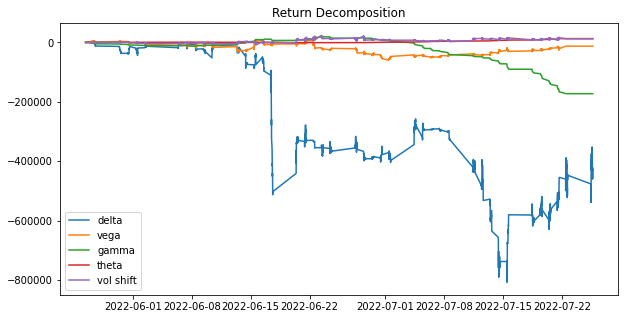

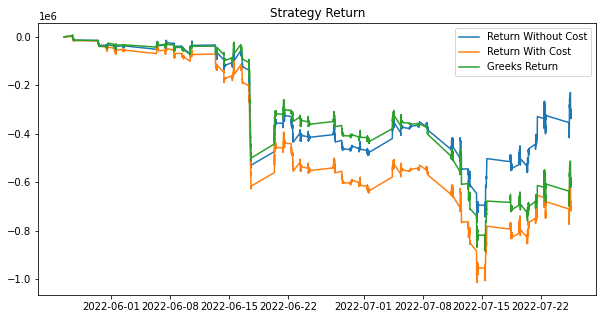

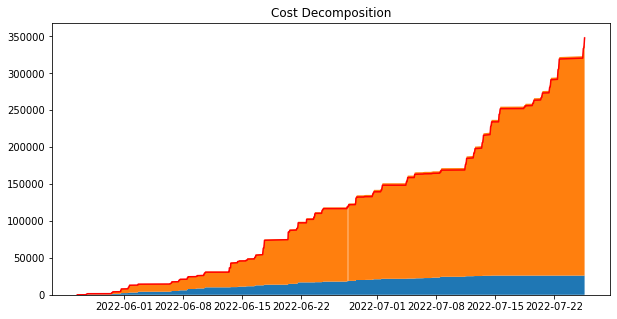

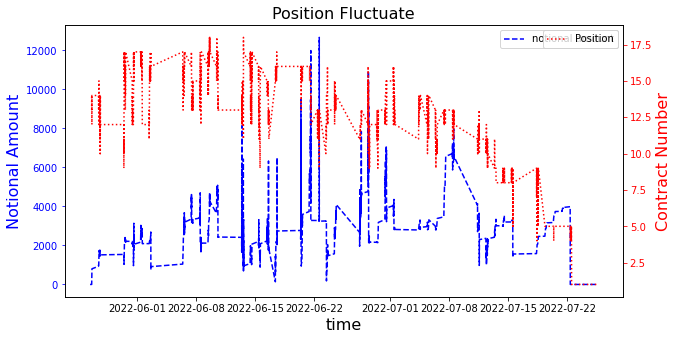

   annualized return  sharpe ratio  maximum drawdown  win ratio
0          -0.267123 -23739.806069         -0.116653   0.484818


0

In [30]:
Backtest(pcpl1)

In [32]:
pcpl2.profit_position = pcpl2.profit_position*-1
pcpl2.hedge_position = pcpl2.hedge_position*-1

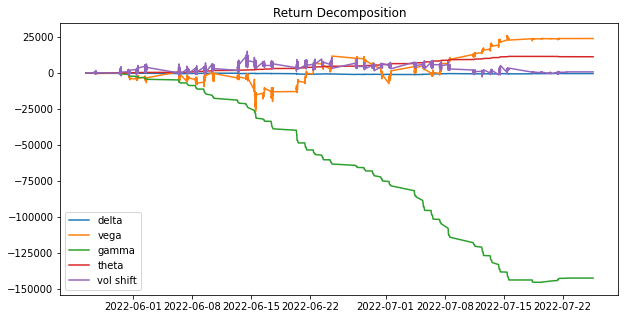

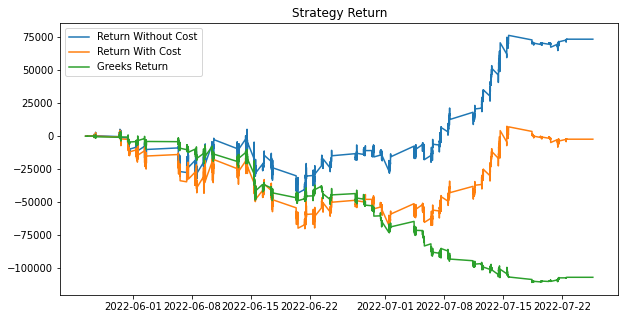

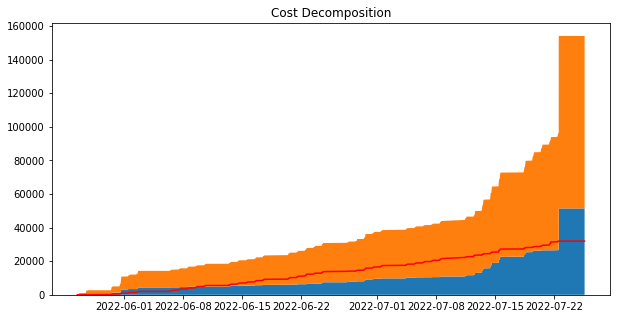

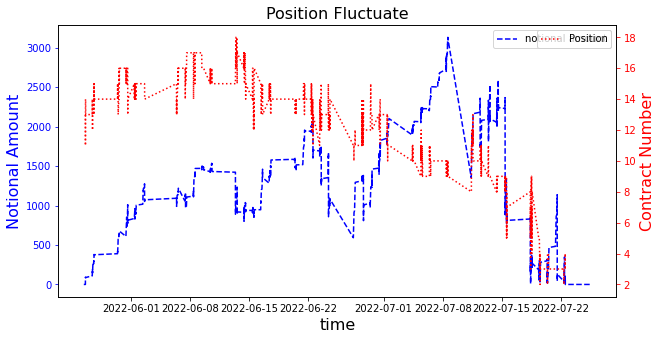

   annualized return  sharpe ratio  maximum drawdown  win ratio
0          -0.038327 -15759.325447         -0.018228   0.496599


0

In [33]:
Backtest(pcpl2)